<a href="https://colab.research.google.com/github/Kuakun55/Stock-price-predicton-Tsla/blob/main/Lstm_predeiction_tsla.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 500)
import matplotlib.pyplot as plt
import tensorflow as tf
import datetime as dt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import warnings
warnings.filterwarnings("ignore")
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [22]:
df = pd.read_csv("/content/TSLA.csv")
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,1.266667,1.666667,1.169333,1.592667,1.592667,281494500
1,2010-06-30,1.719333,2.028000,1.553333,1.588667,1.588667,257806500
2,2010-07-01,1.666667,1.728000,1.351333,1.464000,1.464000,123282000
3,2010-07-02,1.533333,1.540000,1.247333,1.280000,1.280000,77097000
4,2010-07-06,1.333333,1.333333,1.055333,1.074000,1.074000,103003500


In [23]:
def check_df(dataframe,head=5):
  print(" -----------------Head----------------------- ")
  print(dataframe.head(head))
  print("-------------------- Tail----------------------- ")
  print(dataframe.tail(head))
  print("------------------ Shape---------------------- ")
  print(dataframe.shape)
  print(" -----------------Types------------------------ ")
  print(dataframe.dtypes)
  print(" -----------------NA----------------------------")
  print(dataframe.isnull().sum())
  print(" -----------------Qurtiles---------------------- ")
  print(dataframe.describe([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

In [24]:
check_df(df)

 -----------------Head----------------------- 
         Date      Open      High       Low     Close  Adj Close     Volume
0  2010-06-29  1.266667  1.666667  1.169333  1.592667   1.592667  281494500
1  2010-06-30  1.719333  2.028000  1.553333  1.588667   1.588667  257806500
2  2010-07-01  1.666667  1.728000  1.351333  1.464000   1.464000  123282000
3  2010-07-02  1.533333  1.540000  1.247333  1.280000   1.280000   77097000
4  2010-07-06  1.333333  1.333333  1.055333  1.074000   1.074000  103003500
-------------------- Tail----------------------- 
            Date        Open        High         Low       Close   Adj Close     Volume
3187  2023-02-27  202.029999  209.419998  201.259995  207.630005  207.630005  161028300
3188  2023-02-28  210.589996  211.229996  203.750000  205.710007  205.710007  153144900
3189  2023-03-01  206.210007  207.199997  198.520004  202.770004  202.770004  156852800
3190  2023-03-02  186.740005  193.750000  186.009995  190.899994  190.899994  181500700
3191  2

In [25]:
df["Date"] = pd.to_datetime(df["Date"])
tesla_df = df[["Date", "Close"]]
tesla_df.index = tesla_df["Date"]
tesla_df.drop("Date", axis=1, inplace=True)
tesla_df.head()

,Close
Date,
2010-06-29,1.592667
2010-06-30,1.588667
2010-07-01,1.464000
2010-07-02,1.280000
2010-07-06,1.074000


In [26]:
result_df = tesla_df.copy()
tesla_df = tesla_df.values
tesla_df = tesla_df.astype("float32")
tesla_df[0:5]

array([[1.592667],
       [1.588667],
       [1.464   ],
       [1.28    ],
       [1.074   ]], dtype=float32)

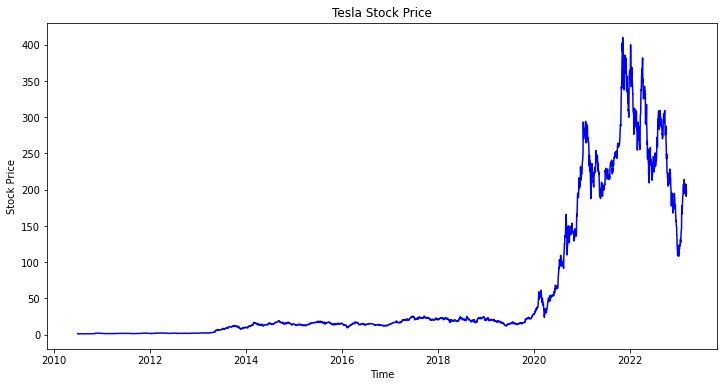

In [27]:
plt.figure(figsize=(12,6))
plt.plot(result_df["Close"], color="blue")
plt.ylabel("Stock Price")
plt.xlabel("Time")
plt.title("Tesla Stock Price")
plt.show()

In [29]:
def split_data(dataframe, test_size):
  position = int(round(len(dataframe) * (1-test_size)))
  train = dataframe[:position]
  test = dataframe[position:]
  return train, test, position

In [30]:
train, test, position = split_data(tesla_df, 0.20)
print("Train shape:", train.shape, " Test shape:", test.shape)

Train shape: (2554, 1)  Test shape: (638, 1)


In [31]:
def encoding_scaling(train, test):
  scaler_train = MinMaxScaler(feature_range=(0,1))
  train = scaler_train.fit_transform(train)
  scaler_test = MinMaxScaler(feature_range=(0,1))
  test = scaler_test.fit_transform(test)
  return scaler_train, train, scaler_test, test

In [32]:
scaler_train, train, scaler_test, test = encoding_scaling(train, test)

In [33]:
def create_features(data, lookback):
  X, Y = [], []
  for i in range(lookback, len(data)):
    X.append(data[i-lookback:i,0])
    Y.append(data[i,0])
  return np.array(X), np.array(Y)

In [34]:
lookback=20
X_train, y_train = create_features(train, lookback)
X_test, y_test = create_features(test, lookback)
print("X_train shape:", X_train.shape, " y_train shape:", y_train.shape, "\nX_test shape:", X_test.shape, " y_test shape: ", y_test.shape)

X_train shape: (2534, 20)  y_train shape: (2534,) 
X_test shape: (618, 20)  y_test shape:  (618,)


In [35]:
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)
print("X_train shape:", X_train.shape, " y_train shape:", y_train.shape, "\nX_test shape:", X_test.shape, " y_test shape: ", y_test.shape)

X_train shape: (2534, 1, 20)  y_train shape: (2534, 1) 
X_test shape: (618, 1, 20)  y_test shape:  (618, 1)


In [36]:
def LSTM_create_and_fit_model(X_train,y_train, X_test, y_test, lookback=20, epochs=100, summary=True, fit=True):
  model = Sequential()
  model.add(LSTM(units=50, activation="relu", input_shape=(X_train.shape[1], lookback)))
  model.add(Dropout(0.2))
  model.add(Dense(1))

  model.compile(loss="mean_squared_error", optimizer="adam")
  callbacks = [EarlyStopping(monitor="val_loss", patience=3, verbose=1, mode="min"), 
              ModelCheckpoint(filepath="mymodel.h5", monitor="val_loss", mode="min", save_best_only=True, save_weights_only=False, verbose=1)]
  
  if summary:
    model.summary()
  
  if fit:
    history = model.fit(x=X_train, y=y_train, epochs=epochs, batch_size=20, 
                      validation_data=(X_test, y_test), callbacks=callbacks, shuffle=False)
  
  return model, history

In [37]:
model, history = LSTM_create_and_fit_model(X_train,y_train, X_test, y_test)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                14200     
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 14,251
Trainable params: 14,251
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
111/127 [=========================>....] - ETA: 0s - loss: 4.1191e-04
Epoch 1: val_loss improved from inf to 0.01178, saving model to mymodel.h5
127/127 [==============================] - 3s 6ms/step - loss: 0.0011 - val_loss: 0.0118
Epoch 2/100
119/127 [===========================>..] - ETA: 0s - loss:

In [38]:
def LSTM_model_evaluate(model):
  loss = model.evaluate(X_test, y_test, batch_size=20)
  print("Test Loss: %.2f" % (100 * loss))
  plt.figure(figsize=(10,5))
  plt.plot(history.history["loss"], color="r", label="Training Loss")
  plt.plot(history.history["val_loss"], color="b", label="Validation Loss")
  plt.legend(loc="upper right")
  plt.xlabel("Epoch", fontsize=16)
  plt.ylabel("Loss", fontsize=16)
  plt.ylim([0, max(plt.ylim())])
  plt.title("Training and Validation Loss", fontsize=16);

31/31 [==============================] - 0s 2ms/step - loss: 0.0086
Test Loss: 0.86


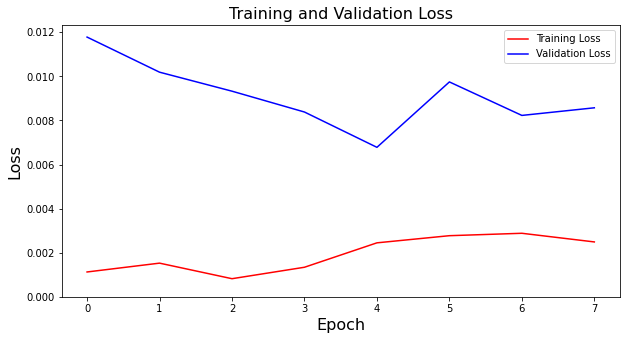

In [39]:
LSTM_model_evaluate(model)

In [40]:
def show_prediction(model, dataframe, X_train, X_test, y_train, y_test, lookback=20, plot=True):
  train_predict = model.predict(X_train)
  test_predict = model.predict(X_test)
  train_predict = scaler_train.inverse_transform(train_predict)
  test_predict = scaler_test.inverse_transform(test_predict) 
  y_train = scaler_train.inverse_transform(y_train)
  y_test = scaler_test.inverse_transform(y_test)
  RMSE_train = np.sqrt(mean_squared_error(y_train, train_predict))
  RMSE_test = np.sqrt(mean_squared_error(y_test, test_predict))
  print("--------------------- Loss ---------------------------")
  print("RMSE Train: ", RMSE_train, "\nRMSE Test: ", RMSE_test)

  train_prediction_df = dataframe[lookback:position]
  train_prediction_df["Predicted"] = train_predict
  print("------------------------ Train Predictoion Head ----------------------------")
  print(train_prediction_df.head())

  test_prediction_df = dataframe[position+lookback:]
  test_prediction_df["Predicted"] = test_predict
  print("------------------------- Test Predictoion Head ---------------------------")
  print(test_prediction_df.head())

  if plot:
    plt.figure(figsize=(14,5))
    plt.plot(dataframe, label="Real Number of Passengers")
    plt.plot(train_prediction_df["Predicted"], color="blue", label="Train Predicted Stock Price")
    plt.plot(test_prediction_df["Predicted"], color="red", label="Test Predicted Stock Price")
    plt.title("Tesla Stock Price Prediction")
    plt.xlabel("Time")
    plt.ylabel("Stock Price")
    plt.legend()
    plt.show()

20/20 [==============================] - 0s 2ms/step
--------------------- Loss ---------------------------
RMSE Train:  3.0012188 
RMSE Test:  27.948938
------------------------ Train Predictoion Head ----------------------------
               Close  Predicted
Date                           
2010-07-28  1.381333   4.199066
2010-07-29  1.356667   4.199066
2010-07-30  1.329333   4.199066
2010-08-02  1.394667   4.199066
2010-08-03  1.463333   4.199066
------------------------- Test Predictoion Head ---------------------------
                 Close   Predicted
Date                              
2020-09-18  147.383331  136.471283
2020-09-21  149.796661  136.502563
2020-09-22  141.410004  135.976608
2020-09-23  126.786667  137.326843
2020-09-24  129.263336  135.476166


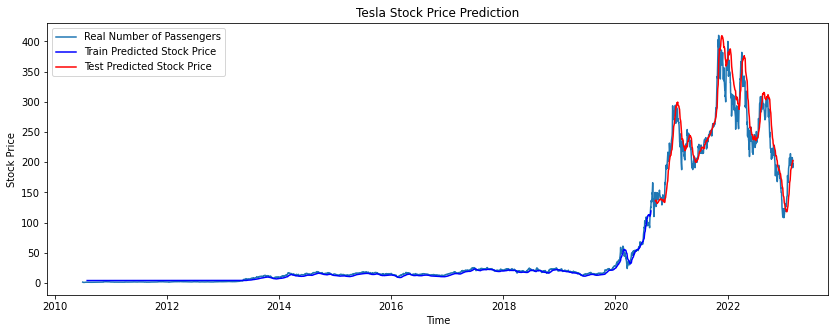

In [41]:
show_prediction(model, result_df, X_train, X_test, y_train, y_test)